In [166]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
import scipy.spatial as spat
import matplotlib.patches as patches
import matplotlib.colors as colors

Import the usual suspects

In [177]:
PITCH = 4.5
alpha = 10
beta_0 = 1.3182817e+7
coupling = 191

## Building and solving a coupling matrix

We want to solve something of the form 

$i \frac{\partial \phi_n}{\partial z} = C_{m, m+a_1} e^{iA((m + a_1) /2)\cdot a_1} \phi_{m+a_1} +  C_{m, m+a_2} e^{iA((m + a_2) /2)\cdot a_2} \phi_{m+a_2}+  C_{m, m+a_3} e^{iA((m + a_3) /2)\cdot a_3} \phi_{m+a_3} + D_n \phi_n $

The first three terms are the effects due to coupling with neighbours, while the fourth term is the on-site change due to the presence of twist.

First let's define a function that handles the effects of twist

Turning to: Ma X et al. 2011 Angular-momentum coupled optical waves in chirally-coupled-core fibers Opt. Expr. 19

They find: $ \beta_{hel} \approx \beta_{straight} \sqrt{1+\alpha^2 R^2}$ 
if $(\alpha R)^2$ is small we can approximate: $\beta_{hel} \approx \beta_{straight} + \frac{\beta_{straight}}{2}(\alpha R)^2$


In [168]:
def twisted_beta(beta_straight, twist_rate, radial_dist):
    beta_hel = beta_straight*np.sqrt(1+ twist_rate**2 * radial_dist**2)
    return beta_hel

vec_twist_beta = np.vectorize(twisted_beta)

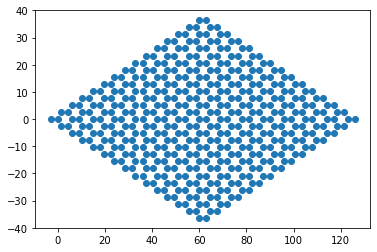

In [169]:
def build_honeycomb(n,m):
    a_1 = np.array([3*PITCH/2, np.sqrt(3)*PITCH/2])
    a_2 = np.array([3*PITCH/2, -np.sqrt(3)*PITCH/2])

    coord_list = []
    for j in range(m):
        for i in range(n): 
            coord_list.append(a_1*i + a_2*j)

    coord_list_shifted = coord_list + np.array([-PITCH, 0])
    coord_list = np.array(coord_list)
    # print(coord_list_shifted)


    full_coord_list = np.concatenate((coord_list, coord_list_shifted), axis=0)

    return full_coord_list
b_10_list = build_honeycomb(15,15)
plt.scatter(b_10_list[:,0], b_10_list[:,1]);    

In [170]:
print(b_10_list[:,0])

[  0.    4.5   9.   13.5  18.   22.5  27.   31.5  36.   40.5  45.   49.5
  54.   58.5  63.    4.5   9.   13.5  18.   22.5  27.   31.5  36.   40.5
  45.   49.5  54.   58.5  63.   67.5   9.   13.5  18.   22.5  27.   31.5
  36.   40.5  45.   49.5  54.   58.5  63.   67.5  72.   13.5  18.   22.5
  27.   31.5  36.   40.5  45.   49.5  54.   58.5  63.   67.5  72.   76.5
  18.   22.5  27.   31.5  36.   40.5  45.   49.5  54.   58.5  63.   67.5
  72.   76.5  81.   22.5  27.   31.5  36.   40.5  45.   49.5  54.   58.5
  63.   67.5  72.   76.5  81.   85.5  27.   31.5  36.   40.5  45.   49.5
  54.   58.5  63.   67.5  72.   76.5  81.   85.5  90.   31.5  36.   40.5
  45.   49.5  54.   58.5  63.   67.5  72.   76.5  81.   85.5  90.   94.5
  36.   40.5  45.   49.5  54.   58.5  63.   67.5  72.   76.5  81.   85.5
  90.   94.5  99.   40.5  45.   49.5  54.   58.5  63.   67.5  72.   76.5
  81.   85.5  90.   94.5  99.  103.5  45.   49.5  54.   58.5  63.   67.5
  72.   76.5  81.   85.5  90.   94.5  99.  103.5 10

Now we want to read in a geometry from COMSOL and find the nearest neighbours

In [171]:
print(np.shape(coord_data))

(1, 257)


In [172]:

coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/honeycomb coord locs small.csv', header=4,float_precision='round_trip')
# coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/coupled_core_locs.csv', header=4,float_precision='round_trip')

#display(coord_data.iloc[:,1:])
x_coords = coord_data.iloc[:,1:128]
y_coords = coord_data.iloc[:,128:]
x_coord_np = x_coords.transpose()[0].to_numpy()
y_coord_np = y_coords.transpose()[0].to_numpy()

combined_list  = np.transpose(np.array((x_coord_np,y_coord_np)))


def build_onsite(beta_straight, twist, coord_pairs):
    distance_to_each_core = np.array([round(np.sqrt(i**2 + j**2),4) for i,j in coord_pairs])*1e-6

    twist_for_each_core = vec_twist_beta(beta_straight, twist, distance_to_each_core) - beta_straight
    onsite_matrix = np.diag(twist_for_each_core)

    return onsite_matrix

Next we build up the vector potential $\mathbf{A}(\mathbf{r})$

In [173]:
def vec_potential(x,y, twist_rate, beta):
    vec_A = twist_rate*beta*np.array([y,-x])
    return vec_A


Finally we stick all of these components into our coupling matrix C

In [174]:
def find_eigvalues(pair_list, pitch, coupling_c, beta_straight, twist):
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=complex)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=100)
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')

    for i in nearest_neighbour_array:
        mid_point = (pair_list[i[0]] + pair_list[i[1]])/2
        a_dist = (pair_list[i[0]] - pair_list[i[1]])*1.0e-6
        # print(mid_point)
        vec_term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, twist, beta_straight)

        coupling_matrix[i[0],i[1]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist))

        a_dist_rev = (pair_list[i[1]] - pair_list[i[0]])*1.0e-6
        coupling_matrix[i[1],i[0]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist_rev))

    onsite_matrix = build_onsite(beta_straight, twist, pair_list)
    full_C = coupling_matrix + onsite_matrix
    print(np.allclose(full_C, np.transpose(np.conjugate(full_C))))
    beta_super, eigvecs = np.linalg.eigh(full_C)

    return beta_super


In [191]:
# beta_100 = beta_super
#print(eigvecs)
# print(beta_super)
beta_vals_1 = find_eigvalues(b_10_list, PITCH, coupling, beta_0, 10)
beta_vals_10 = find_eigvalues(b_10_list, 4.5, 2*coupling, beta_0, 10)
beta_vals_20 = find_eigvalues(b_10_list, 4.5, 3*coupling, beta_0, 10)
beta_vals_30 = find_eigvalues(b_10_list, 3.0, coupling, beta_0, 10)
beta_vals_40 = find_eigvalues(b_10_list, 2.5, coupling, beta_0, 10)

True
True
True
True
True


We now have $i \frac{\partial \mathbf{a}}{\partial z} = C \mathbf{a}$ 
where $\mathbf{a}$ is a vector of complex amplitudes describing the contribution of each single core mode to each supermode

$\beta \mathbf{a} = C \mathbf{a}$

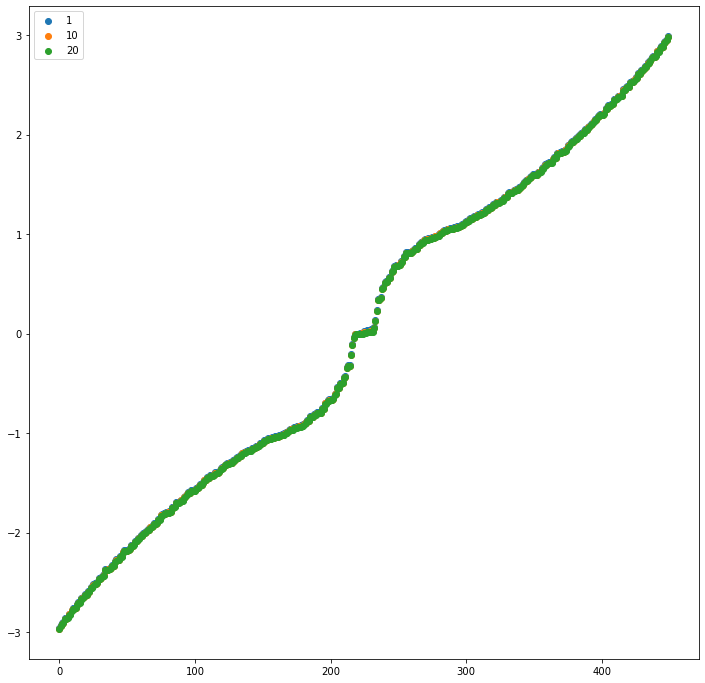

In [194]:
fig1  = plt.figure(figsize=(12,12))   
ax1 = fig1.add_subplot(111)
# ax1.scatter(np.arange(len(beta_super)), beta_10);
# ax1.scatter(np.arange(len(beta_super)), beta_old);
# ax1.scatter(np.arange(len(beta_super)), beta_100);
ax1.scatter(np.arange(len(beta_vals_1)), beta_vals_1/coupling, label='1');
ax1.scatter(np.arange(len(beta_vals_10)), beta_vals_10/(2*coupling), label='10');
ax1.scatter(np.arange(len(beta_vals_20)), beta_vals_20/(3*coupling), label='20');
# ax1.scatter(np.arange(len(beta_vals_30)), beta_vals_30/coupling, label='30');
# ax1.scatter(np.arange(len(beta_vals_40)), beta_vals_40/coupling, label='40');

plt.legend();
